In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 859.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 272.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow


In [ ]:
pip install keras==3.5.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras

from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)


2.17.0
3.5.0


# Loading data

In [ ]:
# Set up the paths to your dataset
train_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/food101/Training'  # Directory containing all training and validation data
test_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/food101/Testing'  # Separate directory for testing data

**econding and image resizing**

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image, ImageFile
import os

# Add this line to avoid errors when reading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def find_corrupted_images(directory):
    """Identify and remove corrupted images in the given directory."""
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupted_images.append(file_path)
                os.remove(file_path)  # Remove corrupted image
    return corrupted_images


# Identify and remove corrupted images
find_corrupted_images(train_dir)
find_corrupted_images(test_dir)

[]

**Splitting data into valiadtion,training and testing without augumentation**





In [ ]:
# #with augumentation

# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.0,
#     validation_split=0.2,  # Use 20% of data for validation
#     rotation_range=40,  # Random rotation between 0 and 40 degrees
#     width_shift_range=0.2,  # Random horizontal shift
#     height_shift_range=0.2,  # Random vertical shift
#     shear_range=0.2,  # Shear intensity
#     zoom_range=0.2,  # Zoom-in and zoom-out
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'  # Filling strategy for augmented images
# )

In [ ]:
# Create ImageDataGenerator instances for training, validation, and testing data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.3,  # Use 20% of data for validation
    )

# ImageDataGenerator for validation and testing data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the images from the directories for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Load the images from the directories for validation
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Load the images from the directory for testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)


Found 11200 images belonging to 20 classes.
Found 3200 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.


# Data Exploration

**Checking if Dataset is imbalance**

{'Training': {'glioma': 240, 'meningioma': 244, 'notumor': 324, 'pituitary': 240}, 'Testing': {'glioma': 60, 'meningioma': 62, 'notumor': 81, 'pituitary': 60}}


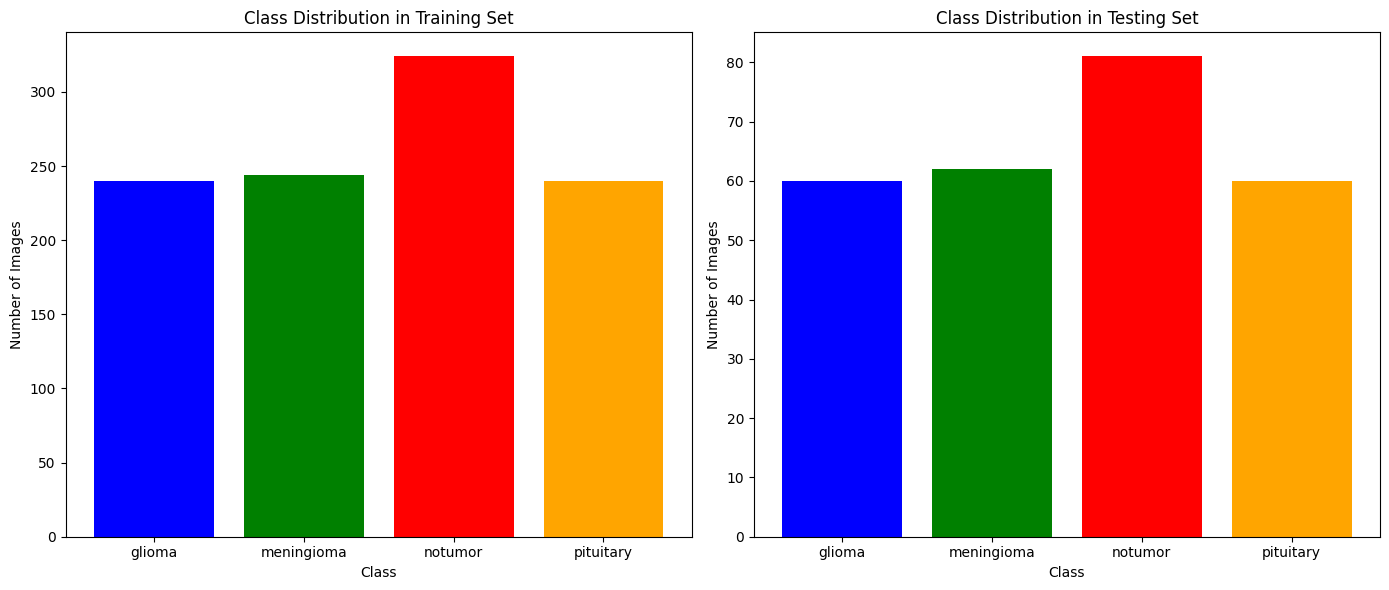

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the paths and parameters
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/food101'

subsets = ['Training', 'Testing']
classes = class_names = ['grilled_salmon', 'guacamole', 'gyoza', 'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels']

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Count the number of images in each class for both training and testing sets
class_counts = {'Training': {}, 'Testing': {}}

for subset in subsets:
    subset_path = os.path.join(dataset_dir, subset)
    for class_name in classes:
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]
            class_counts[subset][class_name] = len(files)

print(class_counts)

# Visualize the class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, subset in enumerate(subsets):
    axes[i].bar(class_counts[subset].keys(), class_counts[subset].values(), color=['blue', 'green', 'red', 'orange'])
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Number of Images')
    axes[i].set_title(f'Class Distribution in {subset.capitalize()} Set')

plt.tight_layout()
plt.show()


**Ploting of Graph**

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Count the number of samples for each class in training, validation, and test sets
train_counts = np.zeros(len(class_labels), dtype=int)
validation_counts = np.zeros(len(class_labels), dtype=int)
test_counts = np.zeros(len(class_labels), dtype=int)

# Compute the counts of each class in the training dataset
for _, labels in train_generator:
    train_counts += np.sum(labels, axis=0).astype(int)

# Compute the counts of each class in the validation dataset
for _, labels in validation_generator:
    validation_counts += np.sum(labels, axis=0).astype(int)

# Compute the counts of each class in the test dataset
for _, labels in test_generator:
    test_counts += np.sum(labels, axis=0).astype(int)

# Function to plot pie chart
def plot_pie_chart(data_counts, data_type):
    plt.figure(figsize=(8, 6))
    plt.pie(data_counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Class Distribution in {data_type} Dataset')
    plt.axis('equal')
    plt.show()

# Function to plot bar chart
def plot_bar_chart(data_counts, data_type):
    plt.figure(figsize=(12, 6))
    plt.bar(class_labels, data_counts, color='skyblue')
    plt.title(f'Class Distribution in {data_type} Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.show()

# Plot pie and bar charts for training, validation, and test datasets
plot_pie_chart(train_counts, 'Training')
plot_bar_chart(train_counts, 'Training')

plot_pie_chart(validation_counts, 'Validation')
plot_bar_chart(validation_counts, 'Validation')

plot_pie_chart(test_counts, 'Test')
plot_bar_chart(test_counts, 'Test')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-bb541ab0f6ba>", line 14, in <cell line: 14>
    for _, labels in train_generator:
  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py", line 112, in __next__
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 2293, in resize
    self.load()
  File "/usr/local/lib/python3.10/dist-packages/PIL/ImageFile.py", line 293, in load
    n, err_

TypeError: object of type 'NoneType' has no len()

# **Displaying sample image**

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

def plot_sample_images(data_generator, title, n_samples=5):
    """
    Plot a grid of sample images from the data generator.

    Parameters:
    - data_generator: The ImageDataGenerator object containing the images.
    - title: The title for the plot (e.g., "Training Data").
    - n_samples: The number of images to display per class.
    """
    # Reset the generator to ensure it starts from the beginning
    data_generator.reset()

    # Create a figure to display images
    plt.figure(figsize=(20, 10))

    # Get class labels and their indices
    class_indices = data_generator.class_indices
    class_labels = list(class_indices.keys())

    # Initialize a counter for subplot index
    plot_index = 1

    # Loop through classes and plot samples
    for class_label in class_labels:
        # Counter for the number of samples per class
        samples_count = 0

        # Loop through batches to find images of the current class
        for images, labels in data_generator:
            for i in range(len(labels)):
                if np.argmax(labels[i]) == class_indices[class_label]:
                    # Plot the image
                    plt.subplot(len(class_labels), n_samples, plot_index)
                    plt.imshow(images[i])
                    plt.title(class_label)
                    plt.axis('off')
                    plot_index += 1
                    samples_count += 1

                    # Stop if we have enough samples for the current class
                    if samples_count >= n_samples:
                        break
            if samples_count >= n_samples:
                break

    plt.suptitle(f'Sample Images from {title}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot a sample of images from the training, validation, and test datasets
plot_sample_images(train_generator, 'Training Data')
plot_sample_images(validation_generator, 'Validation Data')
plot_sample_images(test_generator, 'Test Data')

# Model build and training

In [ ]:
### Model number 1: Fine tuned Densenet201 model

# Copy Densenet201 model and remove fully connected layers

base_model = DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (224,224,3),
    pooling = None
)

# Option here to train on the final Conv5 block in the densenet model ("True") or use imagenet weights for this layer ("False")

# base_model.trainable = False

for layer in base_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

# 3 fully connected layers are added, with 256, 128 and 64 units respectively
# Dropout and Batch Normalization are performed on the fully connected layers.

input = Input(shape = (224,224,3))
layer = base_model(inputs=input)
layer = Flatten()(layer)

layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)

layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)

layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)


layer = Dense(units=25,activation='softmax')(layer)

densenet_model = Model(inputs=input, outputs=layer)



# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Global average pooling layer
# x = Dense(512, activation='relu')(x)  # Fully connected layer

# predictions = Dense(100, activation='softmax')(x)  # Output layer for 100 classes


In [ ]:
densenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 94080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      24,084,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           1,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,449,497 (161.93 MB)

 Trainable params: 31,106,073 (118.66 MB)

 Non-trainable params: 11,343,424 (43.27 MB)

In [ ]:
densenet_model.compile(loss='categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

In [ ]:
# Implement callbacks
model_path ='/content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/denset_food.keras'

checkpoint = ModelCheckpoint(model_path, save_best_only=True,monitor='val_accuracy',mode='max' ,verbose=1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose = 1, mode='min', restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000001)


In [ ]:
# Train model
try:
   densenet_history = densenet_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[learning_rate_reduction, checkpoint,early_stop]  # Use the custom callbacks
    )
except OSError as e:
    print(f"Error during training: {e}")

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1123 - loss: 3.1912
Epoch 1: val_accuracy improved from -inf to 0.37100, saving model to /content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/denset_food.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.1125 - loss: 3.1904 - val_accuracy: 0.3710 - val_loss: 2.2843 - learning_rate: 0.0010
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3572 - loss: 2.1005
Epoch 3: val_accuracy improved from 0.37100 to 0.59675, saving model to /content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/denset_food.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - accuracy: 0.3572 - loss: 2.1003 - val_accuracy: 0.5968 - val_loss: 1.3161 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4698 - loss: 1.7168
Epoch 5: val_accuracy improved from 0.59675 to 0.66800, saving model to /content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/denset_food.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.4698 - loss: 1.7167 - val_accuracy: 0.6680 - val_loss: 1.1268 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = densenet_model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

In [ ]:
import pickle

# Save the training history to a file
with open('/content/drive/MyDrive/Colab Notebooks/Food detection/history/food_desnet_training_history.pkl', 'wb') as file:
    pickle.dump(densenet_history, file)



In [ ]:
densenet_model.save('/content/drive/MyDrive/Colab Notebooks/Food detection/history/models/food_denseNet201.h5')

# Model Evaluation

In [ ]:
# # load the training history from the file:
# with open('/content/drive/MyDrive/Colab Notebooks/brain tumor v1/history/brain_denseNet201_training_history.pkl', 'rb') as file:
#     DenseNet201_history = pickle.load(file)

In [ ]:

#Extract training and validation accuracy values
train_accuracy = densenet_history.history['accuracy']
val_accuracy =densenet_history.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_accuracy) + 1)

In [ ]:
# Create Accuracy and Loss chart function

def plot_accuracy_loss_chart(history,epochs):
    epochs = [i for i in range(epochs)]     #no of each
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

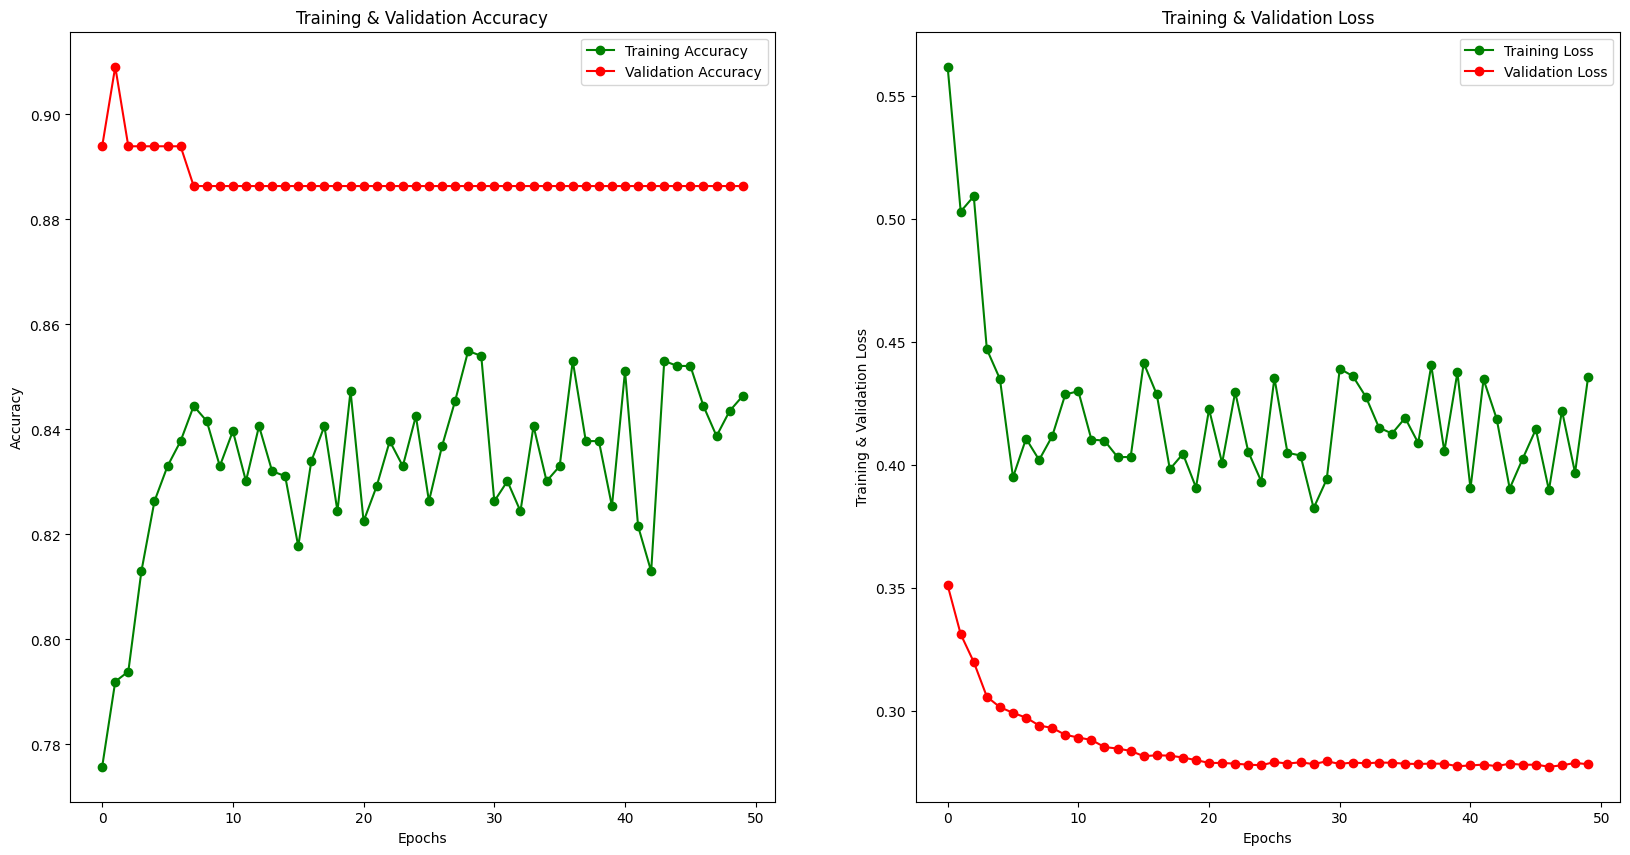

In [ ]:
# Accuracy and Loss charts for Model 2

plot_accuracy_loss_chart(densenet_history)

In [ ]:
# Evaluating the model on the test data

# Evaluate the model on the test set
test_loss, test_acc = densenet_model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")
print(f"\nTest accuracy: {test_loss}")


5/5 [==============================] - 4s 935ms/step - loss: 0.3417 - accuracy: 0.8855
Loss of the model is -  0.341700941324234
Accuracy of the model is -  88.5496199131012 %


**CONFUSION MATRIX**

**INCEPTION V3**

In [ ]:
# Load the Inception V3 model with pretrained ImageNet weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(512, activation='relu')(x)  # Fully connected layer
predictions = Dense(100, activation='softmax')(x)  # Output layer for 100 classes

# Combine the base model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Custom callbacks with notifications
class NotifyCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if self.best == logs.get(self.monitor):
            print(f"Checkpoint saved at epoch {epoch + 1} with {self.monitor}: {self.best:.4f}")

class NotifyEarlyStopping(EarlyStopping):
    def on_epoch_end(self, epoch, logs=None):
        if self.stopped_epoch > 0 and epoch == self.stopped_epoch - self.patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")

# Define custom callbacks
notify_checkpoint = NotifyCheckpoint('best_inception_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
notify_early_stop = NotifyEarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with error handling
try:
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[notify_checkpoint, notify_early_stop]  # Use the custom callbacks
    )
except OSError as e:
    print(f"Error during training: {e}")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")


**CNN**

In [ ]:
# ### Model number 1: Fine tuned Densenet201 model

# # Define the CNN model
# cnn_model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dense(20, activation='softmax')  # Adjusted for 100 classes
# ])
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  # Define the input layer here
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(20, activation='softmax')  # Adjusted for 20 classes
])


In [ ]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 128)       │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       1,384,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,063,220 (7.87 MB)

 Trainable params: 2,063,220 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(loss='categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

In [ ]:
# Implement callbacks
model_path ='/content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/cnn_food.keras'

checkpoint = ModelCheckpoint(model_path, save_best_only=True,monitor='val_accuracy',mode='max' ,verbose=1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose = 1, mode='min', restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.00001)


In [ ]:
# Train model
try:
   cnn_history = cnn_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[learning_rate_reduction, checkpoint,early_stop]  # Use the custom callbacks
    )
except OSError as e:
    print(f"Error during training: {e}")

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0476 - loss: 3.0259
Epoch 1: val_accuracy improved from -inf to 0.04719, saving model to /content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/cnn_food.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 1404s 4s/step - accuracy: 0.0476 - loss: 3.0258 - val_accuracy: 0.0472 - val_loss: 2.9958 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accura

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0555 - loss: 2.9917
Epoch 3: val_accuracy improved from 0.04719 to 0.08906, saving model to /content/drive/MyDrive/Colab Notebooks/Food detection/checkpoint/cnn_food.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 1413s 4s/step - accuracy: 0.0555 - loss: 2.9916 - val_accuracy: 0.0891 - val_loss: 2.9136 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
117/350 ━━━━━━━━━━━━━━━━━━━━ 14:29 4s/step - accuracy: 0.1093 - loss: 2.8566

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = densenet_model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

In [ ]:
import pickle

# Save the training history to a file
with open('/content/drive/MyDrive/Colab Notebooks/Food detection/history/food_cnn_training_history.pkl', 'wb') as file:
    pickle.dump(densenet_history, file)


In [ ]:
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/Food detection/history/models/food_cnn.h5')

#**Model Evaluation**

In [ ]:
 # load the training history from the file:
# with open('/content/drive/MyDrive/Colab Notebooks/brain tumor v1/history/food_cnn_training_history.pkl', 'rb') as file:
#     cnn_history = pickle.load(file)

In [ ]:
#Extract training and validation accuracy values
train_accuracy = cnn_history.history['accuracy']
val_accuracy =cnn_history.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_accuracy) + 1)

In [ ]:
# Create Accuracy and Loss chart function

def plot_accuracy_loss_chart(history,epochs):
    epochs = [i for i in range(epochs)]     #no of each
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [ ]:
# Accuracy and Loss charts for Model 2

plot_accuracy_loss_chart(cnn_history)

In [ ]:
# Evaluating the model on the test data

# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")
print(f"\nTest accuracy: {test_loss}")


#**CONFUSION MATRIX**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict the classes of the test data
test_generator.reset()  # Ensure the generator is at the start
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels

In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()